In [1]:
from helpers import *
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, RobertaTokenizer, LongformerForSequenceClassification
from torchmetrics import F1, Recall, Precision, PrecisionRecallCurve

In [2]:
dataset_path = '/home/u9/kbozler/Documents/outside/reuters-article-classification/data/'
output_path = '/xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/output/longformer-reuters-multilabel'
model_save_dir = os.path.join('/xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/saved-models/longformer-reuters-multilabel')
all_topics = ['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest']
num_labels = len(all_topics)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [3]:
filenames = get_filenames(dataset_path)

In [4]:
dataset_train_dict, dataset_val_dict, dataset_test_dict = build_dataset_dictionaries(dataset_path, 
                                                                                     filenames, 
                                                                                     all_topics)

reut2-015.sgm


/home/u9/kbozler/Documents/outside/reuters-article-classification/helpers.py:29: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 29 of the file /home/u9/kbozler/Documents/outside/reuters-article-classification/helpers.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(data)


reut2-008.sgm
reut2-006.sgm
reut2-010.sgm
reut2-009.sgm
reut2-005.sgm
reut2-003.sgm
reut2-019.sgm
reut2-011.sgm
reut2-016.sgm
reut2-007.sgm
reut2-004.sgm
reut2-012.sgm
reut2-013.sgm
reut2-018.sgm
reut2-002.sgm
reut2-017.sgm
reut2-014.sgm
reut2-000.sgm
reut2-020.sgm
reut2-001.sgm


In [5]:
csv_train, csv_eval, csv_test = write_to_csv(dataset_path, 
                                             all_topics, 
                                             dataset_train_dict, 
                                             dataset_val_dict, 
                                             dataset_test_dict)

In [6]:
raw_datasets = load_dataset('csv', data_files={'train': os.path.join(dataset_path, csv_train),
                                               'eval': os.path.join(dataset_path, csv_eval),
                                               'test': os.path.join(dataset_path, csv_test)})
raw_datasets

Using custom data configuration default-2e9295c49fb71df0


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/u9/kbozler/.cache/huggingface/datasets/csv/default-2e9295c49fb71df0/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest'],
        num_rows: 12668
    })
    eval: Dataset({
        features: ['idx', 'text', 'earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['idx', 'text', 'earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest'],
        num_rows: 5610
    })
})

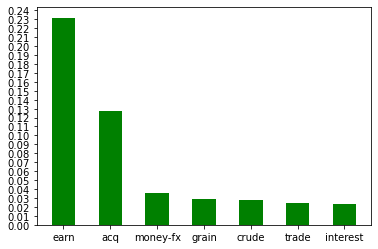

In [7]:
show_histogram_multilabel(all_topics, raw_datasets)

In [8]:
tokenized_datasets = adjust_and_tokenize_datasets(raw_datasets)

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/12668 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/5610 [00:00<?, ?ex/s]

In [9]:
training_args = TrainingArguments(output_path, 
                                  evaluation_strategy="epoch", 
                                  save_strategy="epoch",
                                  per_device_train_batch_size=8, 
                                  per_device_eval_batch_size=8, 
                                  num_train_epochs=6,
                                  learning_rate=2e-5,
                                  logging_steps=1000,
                                  load_best_model_at_end=True)

In [10]:
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', 
                                                            num_labels=num_labels, 
                                                            ignore_mismatched_sizes=True, 
                                                            problem_type='multi_label_classification')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weigh

In [11]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'], 
    tokenizer=tokenizer,
)

In [12]:
trainer.train()

***** Running training *****
  Num examples = 12668
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9504
Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss
1,0.097200,0.051355
2,0.037900,0.043609
3,0.029700,0.049417
4,0.019000,0.049142
5,0.015400,0.049765
6,0.010600,0.051307


Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 488 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 499 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 433 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 414 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 474 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 406 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 414 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 335 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 285 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 356 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 325 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 421 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 375 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 325 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 495 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 401 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 369 to 512 to be a multiple of `conf

Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 456 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 218 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 414 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 303 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 170 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Input ids are automatically padded from 336 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 252 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 396 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 412 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 400 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 271 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 457 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 430 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 396 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 471 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 209 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 479 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 400 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 219 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 331 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 432 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 339 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Input ids are automatically padded from 288 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 315 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 452 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 330 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 144 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializi

Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 448 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 442 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 470 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 452 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 195 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 351 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 211 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 243 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 492 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 375 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 234 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 465 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 507 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 418 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 374 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 343 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 310 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 253 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 433 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 305 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 337 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 360 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 374 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 253 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 310 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 325 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 274 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 456 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 374 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 

Input ids are automatically padded from 395 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 307 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 379 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 296 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 189 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 383 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 391 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 241 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 273 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 208 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 241 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 200 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 

Input ids are automatically padded from 301 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 385 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 406 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 175 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 457 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 226 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 247 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 402 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 457 to 512 to be a multiple of `conf

Input ids are automatically padded from 509 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 378 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 209 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 310 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 346 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 335 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 206 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 221 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 305 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 432 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 369 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 399 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 458 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 294 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 468 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 255 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 506 to 512 to be a multiple of `conf

Input ids are automatically padded from 182 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 419 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 506 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 482 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 329 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 464 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 304 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 434 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 345 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 389 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 470 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 362 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 472 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 340 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 450 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 376 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 360 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 453 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 203 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 396 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 174 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 344 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 273 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 287 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 470 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 394 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 376 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 351 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 285 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 418 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 309 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 337 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 249 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 382 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 496 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 401 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 196 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 301 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 306 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 472 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 420 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 198 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 481 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 429 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 367 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 306 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 185 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 263 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 453 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention 

Input ids are automatically padded from 274 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 242 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 475 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 194 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 307 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 356 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 349 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 399 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 469 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 192 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 389 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 482 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 442 to 512

Initializing global attention on CLS token...
Input ids are automatically padded from 347 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 348 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 330 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 162 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 491 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 367 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 383 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 475 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 302 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 241 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 141 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multipl

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 235 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 329 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 303 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 175 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 289 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Input ids are automatically padded from 408 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 371 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 257 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 443 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 483 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 331 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 425 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 493 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 428 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 369 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 500 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 246 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 444 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 421 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 200 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 371 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 258 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 275 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 231 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 309 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 189 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 326 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 192 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 224 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 460 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `conf

Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 180 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 304 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 279 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 459 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 333 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 353 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 468 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 342 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 416 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 350 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 297 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 262 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 310 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 293 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 466 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 247 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 216 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 239 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 211 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 458 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 317 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 507 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 289 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 343 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 449 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 416 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 416 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 479 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 252 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 268 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 202 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 294 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 245 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Input ids are automatically padded from 443 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 396 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 304 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 472 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Input ids are automatically padded from 266 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 423 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 197 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 390 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 467 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 345 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 349 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 355 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 425 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 338 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 428 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 309 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 401 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 372 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 345 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 188 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 398 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512 to be a multiple of `conf

Input ids are automatically padded from 304 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 202 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 356 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Input ids are automatically padded from 229 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 265 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 134 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 420 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 336 to 512 to be a multiple of `conf

Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 412 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 372 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 300 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 384 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 273 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 325 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 263 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 368 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 174 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 200 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 168 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 254 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 192 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 301 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 385 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 488 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 253 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 307 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 326 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 416 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 342 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 277 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 442 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 456 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 391 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 471 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 346 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 306 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 329 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 393 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 359 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 315 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 384 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 352 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 268 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 176 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 326 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 232 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 369 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 372 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 266 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 390 to 512 to be a multipl

Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 223 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 231 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 229 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 453 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 434 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 398 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 328 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 396 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 248 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Input ids are automatically padded from 424 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 425 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 341 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 222 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 220 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 

Initializing global attention on CLS token...
Input ids are automatically padded from 447 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 245 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 367 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 346 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 442 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 213 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 297 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 487 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 341 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 395 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 496 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 297 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 312 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 257 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 439 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 389 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 215 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 297 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 299 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 462 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 336 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 491 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 459 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 342 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 441 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 160 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 438 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 462 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 402 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 363 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 436 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 351 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 

Input ids are automatically padded from 274 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 452 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 210 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 

Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 202 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 341 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 342 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 349 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 305 to 512 to be a multiple of `conf

Input ids are automatically padded from 208 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 241 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 235 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 329 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 406 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 175 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 289 to 512 to be a multiple of `conf

Input ids are automatically padded from 352 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 420 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 332 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 477 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 296 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 499 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 328 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 444 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 233 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 379 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 346 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 300 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 251 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 395 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 199 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 434 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 414 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 353 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 209 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 281 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 398 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 388 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 324 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 444 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 331 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 223 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 345 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 438 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 436 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 418 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 193 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 509 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 246 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 264 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 312 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 368 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 307 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 467 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 156 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 499 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 398 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 327 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 398 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 377 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 307 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 200 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 314 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 389 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 185 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 373 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 347 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 278 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 423 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 412 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 392 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 483 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 408 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 205 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 190 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 361 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 234 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 261 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 260 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 346 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 285 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 438 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 328 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 487 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 277 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 464 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 510 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 249 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 441 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 435 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 506 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 230 to 512 to be a multiple of `config.attenti

Initializing global attention on CLS token...
Input ids are automatically padded from 496 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 425 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 262 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 463 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 241 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 404 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 141 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Initializi

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 235 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 329 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 303 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Input ids are automatically padded from 427 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 175 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 498 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 289 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention 

Input ids are automatically padded from 260 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 460 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 272 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 428 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 195 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 284 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 395 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 455 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 490 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Input ids are automatically padded from 340 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 349 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 442 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 466 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 328 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 343 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 425 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 497 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 336 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 312 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 308 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 321 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 229 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 280 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 189 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 434 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 244 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 274 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 275 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 321 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 217 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Input ids are automatically padded from 224 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 179 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 215 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 280 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 319 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 297 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 271 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 246 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 224 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 264 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 430 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 444 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 432 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 366 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attenti

Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 479 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 445 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 380 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 323 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 313 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 356 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 453 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 212 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 208 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 363 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 316 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 302 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 471 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 482 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 418 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 198 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 500 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 289 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 402 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 492 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 283 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS tok

Input ids are automatically padded from 285 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 449 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 462 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 172 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 361 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 464 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automa

Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 261 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 417 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 282 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 246 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically pa

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 301 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 352 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 380 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 179 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 318 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 298 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 495 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 247 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Input ids are automatically padded from 198 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 426 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 415 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 469 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 502 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention 

Initializing global attention on CLS token...
Input ids are automatically padded from 299 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 195 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 405 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 423 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 350 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 338 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 472 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 186 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 272 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 363 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 354 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 311 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 162 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 223 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 383 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 178 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automa

TrainOutput(global_step=9504, training_loss=0.031389126924151925, metrics={'train_runtime': 5425.2437, 'train_samples_per_second': 14.01, 'train_steps_per_second': 1.752, 'total_flos': 2.0544021879015336e+16, 'train_loss': 0.031389126924151925, 'epoch': 6.0})

In [13]:
model.save_pretrained(model_save_dir)

Configuration saved in /xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/saved-models/longformer-reuters-multilabel/config.json
Model weights saved in /xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/saved-models/longformer-reuters-multilabel/pytorch_model.bin


In [14]:
model = LongformerForSequenceClassification.from_pretrained(model_save_dir)
model.config
trainer = Trainer(
    model,
    tokenizer=tokenizer,
)

loading configuration file /xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/saved-models/longformer-reuters-multilabel/config.json
Model config LongformerConfig {
  "_name_or_path": "allenai/longformer-base-4096",
  "architectures": [
    "LongformerForSequenceClassification"
  ],
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,

In [15]:
predictions = trainer.predict(tokenized_datasets['test'])

***** Running Prediction *****
  Num examples = 5610
  Batch size = 8
Initializing global attention on CLS token...
Input ids are automatically padded from 157 to 512 to be a multiple of `config.attention_window`: 512


Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 224 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 242 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 364 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 290 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 496 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 181 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 232 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 310 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 273 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 331 to 512 to be a multiple of `conf

Initializing global attention on CLS token...
Input ids are automatically padded from 359 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 421 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 157 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 315 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 412 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 287 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 330 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 242 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 175 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 238 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 236 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 180 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 184 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 303 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 269 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automa

Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 296 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 199 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 182 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 366 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

Initializing global attention on CLS token...
Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 325 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 225 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 366 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 214 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 497 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 294 to 512 to be a multipl

Initializing global attention on CLS token...
Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 505 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 323 to 512 to be a m

Input ids are automatically padded from 295 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 326 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 506 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 259 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 407 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 192 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 402 to 512 to be a multipl

Input ids are automatically padded from 270 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 439 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 348 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 309 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Initializing global attention on CLS token...
Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Initializing global attention on CLS token...
Input ids are automatically padded from 369 to 512 to be a multiple of `config.attention_window`: 512
Initializing global 

In [16]:
predictions.label_ids

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
preds = torch.sigmoid(torch.tensor(predictions.predictions))
threshold = torch.tensor([0.5])
predicted_labels = (preds>threshold).float()*1
target = torch.tensor(predictions.label_ids, dtype=torch.int8)

In [18]:
f1 = F1(num_classes=num_labels, average=None)
precision = Precision(num_classes=num_labels, average=None)
recall = Recall(num_classes=num_labels, average=None)
#curve = PrecisionRecallCurve()

In [19]:
f1(predicted_labels, target)

tensor([0.7984, 0.8943, 0.6868, 0.8750, 0.8620, 0.7167, 0.7210])

In [20]:
precision(predicted_labels, target)

tensor([0.6703, 0.8848, 0.5869, 0.9015, 0.7846, 0.6719, 0.7636])

In [21]:
recall(predicted_labels, target)

tensor([0.9872, 0.9040, 0.8278, 0.8500, 0.9563, 0.7679, 0.6829])